In [ ]:
!pip install tensorflow
!pip install scikit-learn
!pip install keras
!pip install pillow
!pip install matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


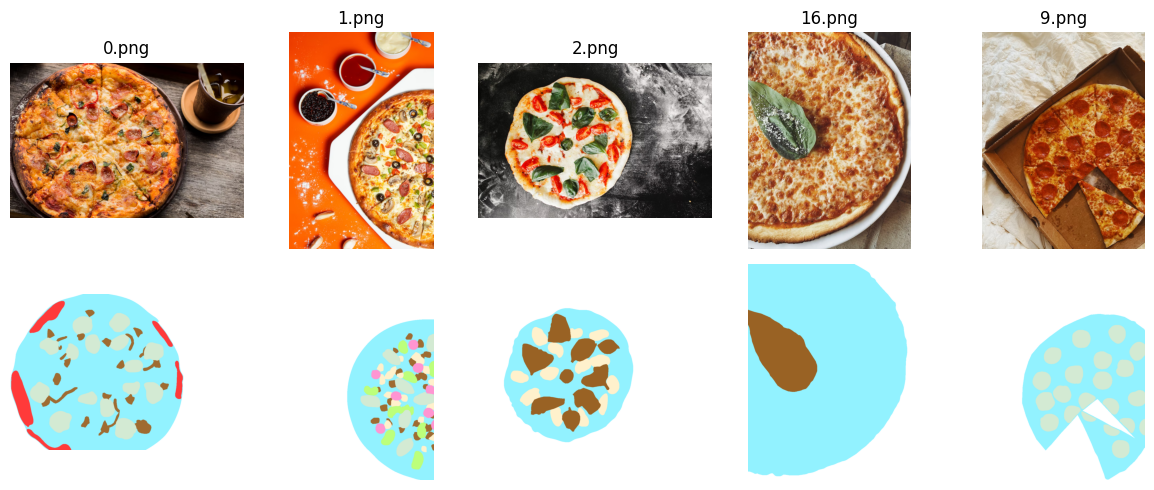

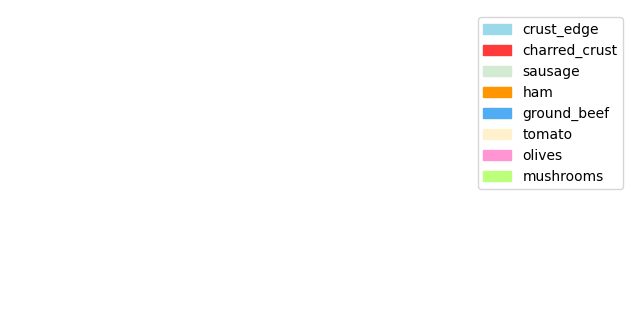

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import os

# Load the Excel sheet
excel_file = '/content/drive/MyDrive/food segmentation/masks_info.csv'
df_colors = pd.read_csv(excel_file, delimiter=';')


# Define the directories for images and masks
image_dir = '/content/drive/MyDrive/food segmentation/Food Segmentation/images'
mask_dir = '/content/drive/MyDrive/food segmentation/Food Segmentation/masks'

# Display 5 images and masks
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))

for i, image_name in enumerate(os.listdir(image_dir)[:5]):
    img_path = os.path.join(image_dir, image_name)
    mask_path = os.path.join(mask_dir, image_name)

    img = mpimg.imread(img_path)
    mask = mpimg.imread(mask_path)

    ax_img = axes[0, i]
    ax_img.imshow(img)
    ax_img.axis('off')
    ax_img.set_title(image_name)

    ax_mask = axes[1, i]
    ax_mask.imshow(mask)
    ax_mask.axis('off')

plt.tight_layout()
plt.show()

# Display 5 images and masks overlaid
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))

for i, image_name in enumerate(os.listdir(image_dir)[:5]):
    img_path = os.path.join(image_dir, image_name)
    mask_path = os.path.join(mask_dir, image_name)

    img = mpimg.imread(img_path)
    mask = mpimg.imread(mask_path)

    ax = axes[i]
    ax.imshow(img)
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
    ax.set_title(image_name)

plt.tight_layout()
plt.show()

# Convert color codes to RGBA format
df_colors['RGBA'] = df_colors['Colour'].apply(lambda x: mcolors.to_rgba(x))

# Create color patches for each food type
color_patches = [
    mpatches.Patch(color=color_code, label=food_type)
    for food_type, color_code in zip(df_colors['Element'], df_colors['RGBA'])
]

# Visualize the color codes
fig, ax = plt.subplots(figsize=(8, 4))
ax.legend(handles=color_patches)
ax.axis('off')
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.colors as mcolors

# Load the Excel sheet
excel_file = '/content/drive/MyDrive/food segmentation/masks_info.csv'
df_colors = pd.read_csv(excel_file, delimiter=';')

# Define the directories for images and masks
image_dir = '/content/drive/MyDrive/food segmentation/Food Segmentation/images'
mask_dir = '/content/drive/MyDrive/food segmentation/Food Segmentation/masks'

# Read image and mask file names
image_files = sorted(os.listdir(image_dir))[:16]  # Use first 16 images for training
mask_files = sorted(os.listdir(mask_dir))[:16]    # Use first 16 masks for training

# Load and preprocess images and masks
X_train = []
y_train = []

for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)

    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Preprocess image and mask (resize, normalize, etc.)
    image = image.resize((256, 256))  # Adjust size as per your requirements
    mask = mask.resize((256, 256))

    image = np.array(image) / 255.0  # Normalize image to [0, 1]
    mask = np.array(mask)

    X_train.append(image)
    y_train.append(mask)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Define the U-Net model
inputs = Input((256, 256, 3))  # Assuming RGB images
s = inputs

# Encoder
c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(s)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

# Decoder
c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(c6)
u7 = concatenate([UpSampling2D((2, 2))(c6), c1])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

model = Model(inputs=[inputs], outputs=[outputs])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Visualize the model
model.summary()

# Test the model with the last four images and masks
X_test_last4 = X_test[-4:]
y_test_last4 = y_test[-4:]

# Predict masks for the last four images
y_pred_last4 = model.predict(X_test_last4)
y_pred_last4_bin = (y_pred_last4 > 0.5).astype(np.uint8)

print(df_colors)

# Prepare color map from the CSV file
color_map = {}
for index, row in df_colors.iterrows():
    color_map[row['Element']] = [row['Colour']]

# Visualize the results
fig, axes = plt.subplots(4, 3, figsize=(12, 16))

for i, ax in enumerate(axes):
    # Display the original image
    ax[0].imshow(X_test_last4[i])
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    # Display the true mask
    ax[1].imshow(y_test_last4[i].squeeze())
    ax[1].axis('off')
    ax[1].set_title('True Mask')

    # Convert predicted mask to RGB format
    predicted_mask_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    for label, color in color_map.items():
      color_hex = color[0].lstrip('#')
      color_rgb = tuple(int(color_hex[i:i+2], 16) for i in (0, 2, 4))
      color_rgba = color_rgb + (255,)
      indices = np.where(y_pred_last4_bin[i].squeeze() == label)

    if indices[0].size > 0 and indices[1].size > 0:
        predicted_mask_rgb[indices[0], indices[1]] = np.array(color_rgba, dtype=np.uint8)







    # Display the predicted mask
    ax[2].imshow(predicted_mask_rgb)
    ax[2].axis('off')
    ax[2].set_title('Predicted Mask')


plt.tight_layout()
plt.show()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

<ipython-input-1-3aafb96cb536>:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  indices = np.where(y_pred_last4_bin[i].squeeze() == label)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.colors as mcolors

# Load the Excel sheet
excel_file = r'C:\Users\salty\Desktop\food segmentation\masks_info.csv'
df_colors = pd.read_csv(excel_file, delimiter=';')

# Define the directories for images and masks
image_dir = r'C:\Users\salty\Desktop\food segmentation\food segmentation\images'
mask_dir = r'C:\Users\salty\Desktop\food segmentation\food segmentation\masks'

# Read image and mask file names
image_files = sorted(os.listdir(image_dir))[:16]  # Use first 16 images for training
mask_files = sorted(os.listdir(mask_dir))[:16]    # Use first 16 masks for training

# Load and preprocess images and masks
X_train = []
y_train = []

for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)

    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Preprocess image and mask (resize, normalize, etc.)
    image = image.resize((256, 256))  # Adjust size as per your requirements
    mask = mask.resize((256, 256))

    image = np.array(image) / 255.0  # Normalize image to [0, 1]
    mask = np.array(mask)

    X_train.append(image)
    y_train.append(mask)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Define the U-Net model
inputs = Input((256, 256, 3))  # Assuming RGB images
s = inputs

# Encoder
c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(s)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

# Decoder
c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(c6)
u7 = concatenate([UpSampling2D((2, 2))(c6), c1])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

model = Model(inputs=[inputs], outputs=[outputs])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Visualize the model
model.summary()

# Test the model with the last four images and masks
X_test_last4 = X_test[-4:]
y_test_last4 = y_test[-4:]

# Predict masks for the last four images
y_pred_last4 = model.predict(X_test_last4)
y_pred_last4_bin = (y_pred_last4 > 0.5).astype(np.uint8)

print(df_colors)

# Prepare color map from the CSV file
color_map = {}
for index, row in df_colors.iterrows():
    color_map[row['Element']] = [row['Colour']]

# Visualize the results
fig, axes = plt.subplots(4, 3, figsize=(12, 16))

for i, ax in enumerate(axes):
    # Display the original image
    ax[0].imshow(X_test_last4[i])
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    # Display the true mask
    ax[1].imshow(y_test_last4[i].squeeze(), cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('True Mask')

    # Convert predicted mask to RGB format
    predicted_mask_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    for label, color in color_map.items():
      color_hex = color[0].lstrip('#')
      color_rgb = tuple(int(color_hex[i:i+2], 16) for i in (0, 2, 4))
      color_rgba = color_rgb + (255,)
      indices = np.where(y_pred_last4_bin[i].squeeze() == label)

    if indices[0].size > 0 and indices[1].size > 0:
        predicted_mask_rgb[indices[0], indices[1]] = np.array(color_rgba, dtype=np.uint8)


    # Display the predicted mask
    ax[2].imshow(predicted_mask_rgb)
    ax[2].axis('off')
    ax[2].set_title('Predicted Mask')


plt.tight_layout()
plt.show()


FileNotFoundError: ignored

NameError: ignored